In [12]:
import pandas as pd
from datasets import load_dataset
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

/Users/daniel/Documents/Projects/Python/Natural-Language-Processing/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

print("Downloading dataset...")
dataset = load_dataset("boltuix/emotions-dataset", split='train')
df = dataset.to_pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Generating train split: 100%|█| 131306/131306 [00:00<00:00, 2260306.67 examples/


In [21]:
print("FIRST 5 ROWS:")
print(df.head())

print("\nDATASET INFORMATION:")
print(df.info())

print("\nLABEL DISTRIBUTION:")
print(df["Label"].value_counts())

FIRST 5 ROWS:
                                            Sentence      Label
0  Unfortunately later died from eating tainted m...  happiness
1  Last time I saw was loooong ago. Basically bef...    neutral
2  You mean by number of military personnel? Beca...    neutral
3  Need to go middle of the road no NAME is going...    sadness
4           feel melty miserable enough imagine must    sadness

DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131306 entries, 0 to 131305
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Sentence  131306 non-null  object
 1   Label     131306 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB
None

LABEL DISTRIBUTION:
Label
happiness    31205
sadness      17809
neutral      15733
anger        13341
love         10512
fear          8795
disgust       8407
confusion     8209
surprise      4560
shame         4248
guilt         3470
sarcasm       2534
desire        

In [31]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence, re.I|re.A)

    tokens = sentence.split(" ")
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words:
            cleaned_tokens.append(lemmatizer.lemmatize(word))

    return " ".join(cleaned_tokens)

df["Cleaned_Sentence"] = df["Sentence"].apply(preprocess_sentence)

print("ORIGINAL FIRST SENTENCE:")
print(df["Sentence"].iloc[0])

print("\nCLEANED FIRST SENTENCE:")
print(df["Cleaned_Sentence"].iloc[0])

/var/folders/4d/9x6fqw7131x1ct12ncm22bl40000gn/T/ipykernel_2202/3347930940.py:6: DeprecationWarning: 'count' is passed as positional argument
  sentence = re.sub(r'[^a-zA-Z\s]', '', sentence, re.I|re.A)


ORIGINAL FIRST SENTENCE:
Unfortunately later died from eating tainted meat NAME BBC documentary dynasties followed the marsh pride the lion episode was awesome

CLEANED FIRST SENTENCE:
unfortunately later died eating tainted meat name bbc documentary dynasty followed marsh pride lion episode awesome


In [36]:
x = df["Cleaned_Sentence"]
y = df["Label"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)
print("Total samples: {}".format(len(x)))
print("Training samples: {}".format(len(x_train)))
print("Testing samples: {}".format(len(x_test)))

Total samples: 131306
Training samples: 105044
Testing samples: 26262


In [38]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

print("SHAPE OF NEW VECTORS:")
print("Training vectors shape: {}".format(x_train_tfidf.shape))
print("Test vectors shape: {}".format(x_test_tfidf.shape))

SHAPE OF NEW VECTORS:
Training vectors shape: (105044, 5000)
Test vectors shape: (26262, 5000)


In [39]:
nb_model = MultinomialNB()

print("Training the model...")
nb_model.fit(x_train_tfidf, y_train)
print("Training complete!")

Training the model...
Training complete!


In [41]:
y_pred = nb_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(accuracy))

label_names = df["Label"].unique()
label_names.sort()

report = classification_report(y_test, y_pred, target_names=label_names)
print(report)

Accuracy: 0.5022846698652045
              precision    recall  f1-score   support

       anger       0.55      0.43      0.48      2668
   confusion       0.38      0.07      0.11      1642
      desire       0.98      0.55      0.71       497
     disgust       0.59      0.24      0.34      1681
        fear       0.82      0.48      0.61      1759
       guilt       0.77      0.24      0.36       694
   happiness       0.42      0.88      0.57      6241
        love       0.72      0.21      0.32      2102
     neutral       0.35      0.35      0.35      3147
     sadness       0.62      0.71      0.67      3562
     sarcasm       0.96      0.86      0.91       507
       shame       0.75      0.21      0.33       850
    surprise       0.81      0.07      0.13       912

    accuracy                           0.50     26262
   macro avg       0.67      0.41      0.45     26262
weighted avg       0.57      0.50      0.47     26262



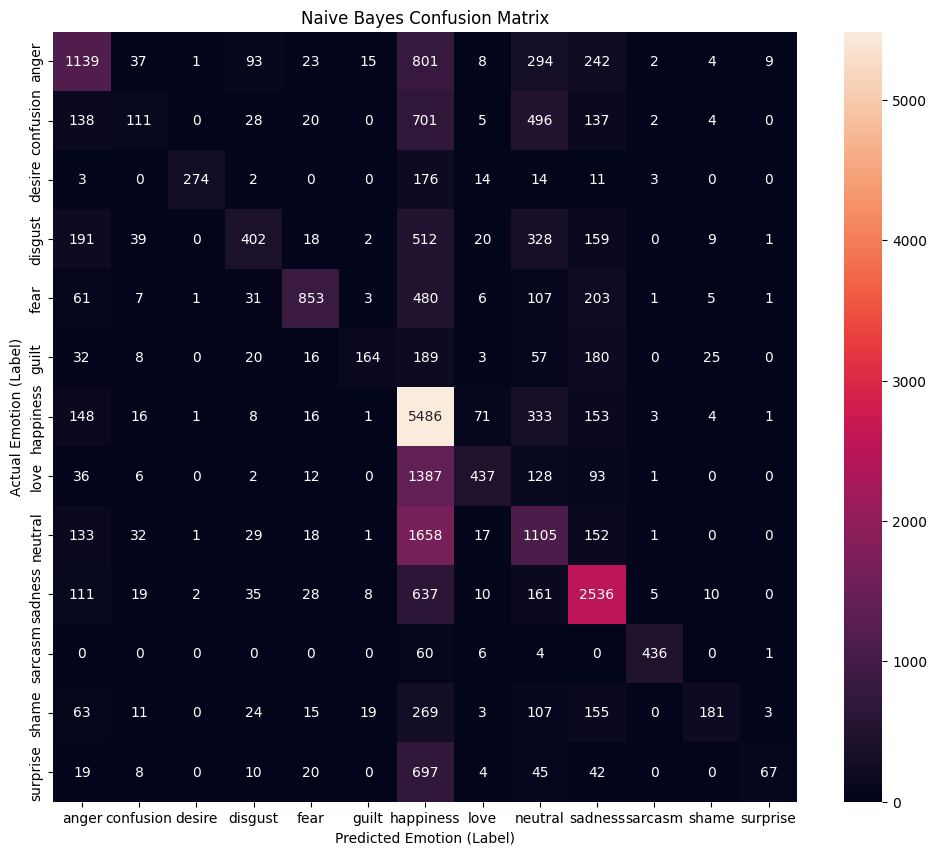

In [42]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names)

plt.xlabel("Predicted Emotion (Label)")
plt.ylabel("Actual Emotion (Label)")
plt.title("Naive Bayes Confusion Matrix")

plt.show()